1) Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder

2) Load the dataset

In [2]:
data = pd.read_csv('youtube_channel_real_performance_analytics.csv')

In [3]:
data.head()

,ID,Video Duration,Video Publish Time,Days Since Publish,Day,Month,Year,Day of Week,Revenue per 1000 Views (USD),Monetized Playbacks (Estimate),...,Watched (Not Skipped) (%),Feed Impressions,Average View Percentage (%),Average View Duration,Views,Watch Time (hours),Subscribers,Estimated Revenue (USD),Impressions,Video Thumbnail CTR (%)
0,0,201,02-06-2016 00:00,0,2,6,2016,Thursday,0.024,723,...,0,0,40.38,81,23531,533.1636,51,0.561,41118,27.66
1,1,391,10-06-2016 00:00,8,10,6,2016,Friday,0.056,727,...,0,0,39.85,156,11478,500.5628,33,0.648,41627,5.85
2,2,133,14-06-2016 00:00,4,14,6,2016,Tuesday,0.014,76,...,0,0,30.88,41,6153,70.7287,8,0.089,38713,7.07
3,3,14,29-06-2016 00:00,15,29,6,2016,Wednesday,0.004,18,...,0,0,103.05,14,4398,17.6251,2,0.017,35245,5.60
4,4,45,01-07-2016 00:00,2,1,7,2016,Friday,0.000,0,...,0,0,55.70,25,14659,104.3341,28,0.000,46218,8.62


In [4]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Data columns (total 70 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   ID                                  364 non-null    int64  
 1   Video Duration                      364 non-null    int64  
 2   Video Publish Time                  364 non-null    object 
 3   Days Since Publish                  364 non-null    int64  
 4   Day                                 364 non-null    int64  
 5   Month                               364 non-null    int64  
 6   Year                                364 non-null    int64  
 7   Day of Week                         364 non-null    object 
 8   Revenue per 1000 Views (USD)        364 non-null    float64
 9   Monetized Playbacks (Estimate)      364 non-null    int64  
 10  Playback-Based CPM (USD)            364 non-null    float64
 11  CPM (USD)                           364 non-n

3) Data cleaning

In [5]:
# Check for missing values
print("Missing values per column:")
print(data.isnull().sum())

# Fill missing numerical values with the mean
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns
data[numerical_columns] = data[numerical_columns].fillna(data[numerical_columns].mean())

# Fill missing categorical values with the mode
categorical_columns = data.select_dtypes(include=['object']).columns
data[categorical_columns] = data[categorical_columns].fillna(data[categorical_columns].mode().iloc[0])

# Drop duplicate rows if any
data = data.drop_duplicates()

# Verify that missing values have been handled
print("Missing values after cleaning:")
print(data.isnull().sum())


Missing values per column:
ID                         0
Video Duration             0
Video Publish Time         0
Days Since Publish         0
Day                        0
                          ..
Watch Time (hours)         0
Subscribers                0
Estimated Revenue (USD)    0
Impressions                0
Video Thumbnail CTR (%)    0
Length: 70, dtype: int64
Missing values after cleaning:
ID                         0
Video Duration             0
Video Publish Time         0
Days Since Publish         0
Day                        0
                          ..
Watch Time (hours)         0
Subscribers                0
Estimated Revenue (USD)    0
Impressions                0
Video Thumbnail CTR (%)    0
Length: 70, dtype: int64


In [6]:
# Check for missing or invalid durations
print(data['Video Duration'].isnull().sum())

# Fill missing durations with the mean or median duration
data['Video Duration'] = data['Video Duration'].fillna(data['Video Duration'].mean())


0


Feature engineering

In [7]:
data['Video Publish Time'] = pd.to_datetime(data['Video Publish Time'])

In [8]:
# Extract additional time-related features
data['Publish Hour'] = data['Video Publish Time'].dt.hour
data['Publish Day'] = data['Video Publish Time'].dt.day
data['Publish Month'] = data['Video Publish Time'].dt.month
data['Publish Year'] = data['Video Publish Time'].dt.year
data['Day of Week'] = data['Video Publish Time'].dt.dayofweek

# Example: Calculate revenue per view
data['Revenue per View'] = data['Estimated Revenue (USD)'] / data['Views']

# Drop columns that are unnecessary for analysis
data = data.drop(['Video Publish Time'], axis=1)

# Display the first few rows after feature engineering
print(data.head())


   ID  Video Duration  Days Since Publish  Day  Month  Year  Day of Week  \
0   0             201                   0    2      6  2016            5   
1   1             391                   8   10      6  2016            3   
2   2             133                   4   14      6  2016            1   
3   3              14                  15   29      6  2016            2   
4   4              45                   2    1      7  2016            3   

   Revenue per 1000 Views (USD)  Monetized Playbacks (Estimate)  \
0                         0.024                             723   
1                         0.056                             727   
2                         0.014                              76   
3                         0.004                              18   
4                         0.000                               0   

   Playback-Based CPM (USD)  ...  Watch Time (hours)  Subscribers  \
0                     1.386  ...            533.1636           51   
1 

In [9]:
# Display summary statistics
print(data.describe())

               ID  Video Duration  Days Since Publish         Day       Month  \
count  364.000000      364.000000          364.000000  364.000000  364.000000   
mean   181.500000      664.239011            8.406593   15.807692    6.642857   
std    105.221988      330.646183           15.371239    8.924004    3.421521   
min      0.000000        9.000000            0.000000    1.000000    1.000000   
25%     90.750000      496.000000            3.000000    8.000000    4.000000   
50%    181.500000      613.000000            5.000000   16.000000    7.000000   
75%    272.250000      786.500000            9.000000   23.000000   10.000000   
max    363.000000     2311.000000          260.000000   31.000000   12.000000   

              Year  Day of Week  Revenue per 1000 Views (USD)  \
count   364.000000   364.000000                    364.000000   
mean   2018.736264     3.134615                      0.112283   
std       2.530629     2.004406                      0.179668   
min    201

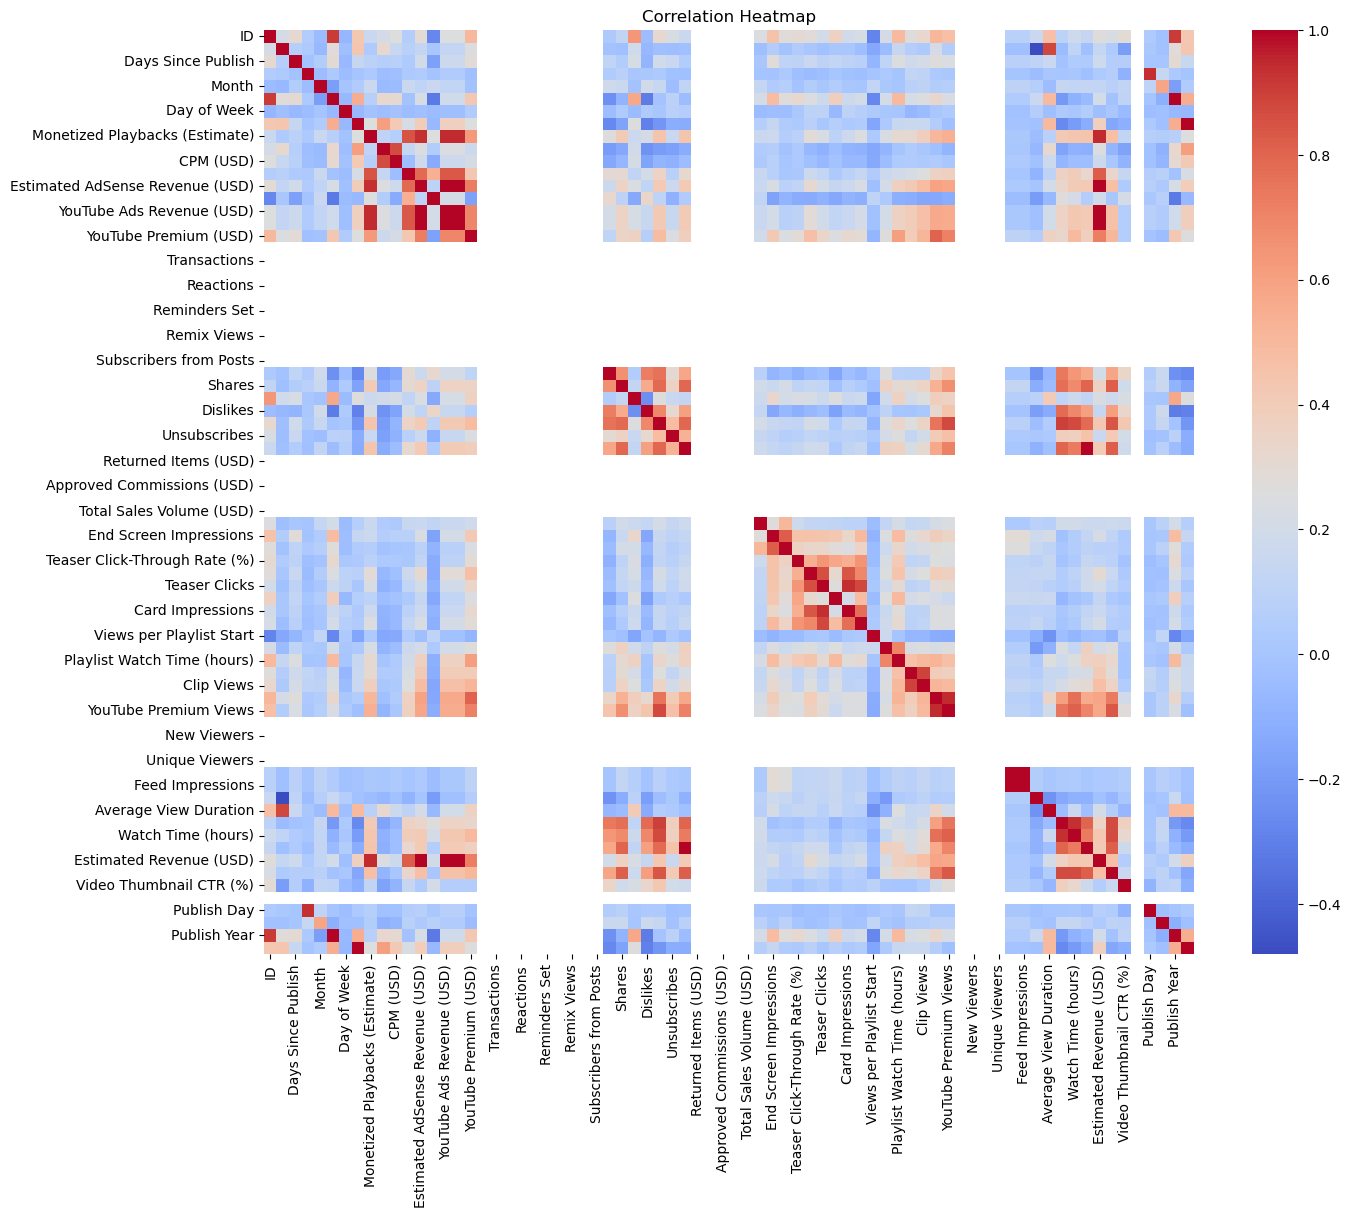

In [10]:
# Select only numeric columns
numeric_df = data.select_dtypes(include=[np.number])
# Compute the correlation matrix
corr = numeric_df.corr()
# Plot the heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(corr, cmap='coolwarm', annot=False, fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

In [11]:
# Check the first few values of 'Video Duration'
print(data['Video Duration'].head())


0    201
1    391
2    133
3     14
4     45
Name: Video Duration, dtype: int64


In [12]:
import isodate

# Helper function to parse ISO 8601 duration or handle non-string values
def parse_video_duration(duration):
    try:
        # If it's already numeric, assume it's in seconds
        if isinstance(duration, (int, float)):
            return duration
        # If it's a string, try parsing as ISO 8601
        elif isinstance(duration, str):
            return isodate.parse_duration(duration).total_seconds()
        else:
            return None  # For completely invalid entries
    except:
        return None  # Handle invalid strings

# Apply the function to parse 'Video Duration'
data['Video Duration (Seconds)'] = data['Video Duration'].apply(parse_video_duration)

# Separate invalid rows for further analysis
invalid_durations = data[data['Video Duration (Seconds)'].isnull()]

# Optional: Fill missing values intelligently (e.g., based on the mean or related features)
data['Video Duration (Seconds)'] = data['Video Duration (Seconds)'].fillna(data['Video Duration (Seconds)'].mean())

# Check the updated DataFrame
print(data[['Video Duration', 'Video Duration (Seconds)']].head())
print("Invalid rows:", invalid_durations)


   Video Duration  Video Duration (Seconds)
0             201                       201
1             391                       391
2             133                       133
3              14                        14
4              45                        45
Invalid rows: Empty DataFrame
Columns: [ID, Video Duration, Days Since Publish, Day, Month, Year, Day of Week, Revenue per 1000 Views (USD), Monetized Playbacks (Estimate), Playback-Based CPM (USD), CPM (USD), Ad Impressions, Estimated AdSense Revenue (USD), DoubleClick Revenue (USD), YouTube Ads Revenue (USD), Watch Page Ads Revenue (USD), YouTube Premium (USD), Transaction Revenue (USD), Transactions, Revenue from Transactions (USD), Reactions, Chat Messages Count, Reminders Set, Stream Hours, Remix Views, Remix Count, Subscribers from Posts, New Comments, Shares, Like Rate (%), Dislikes, Likes, Unsubscribes, New Subscribers, Returned Items (USD), Unconfirmed Commissions (USD), Approved Commissions (USD), Orders, Total Sales

In [13]:
# Calculate engagement rate
data['Engagement Rate'] = (data['Likes'] + data['New Comments'] + data['Shares']) / data['Views']


In [14]:
# Normalize video duration
scaler = MinMaxScaler()
data['Normalized Duration'] = scaler.fit_transform(data[['Video Duration']])

# Categorize duration
def categorize_duration(seconds):
    if seconds < 300:  # less than 5 minutes
        return 'Short'
    elif 300 <= seconds <= 1200:  # 5 to 20 minutes
        return 'Medium'
    else:  # more than 20 minutes
        return 'Long'

data['Duration Category'] = data['Video Duration'].apply(categorize_duration)


EDA

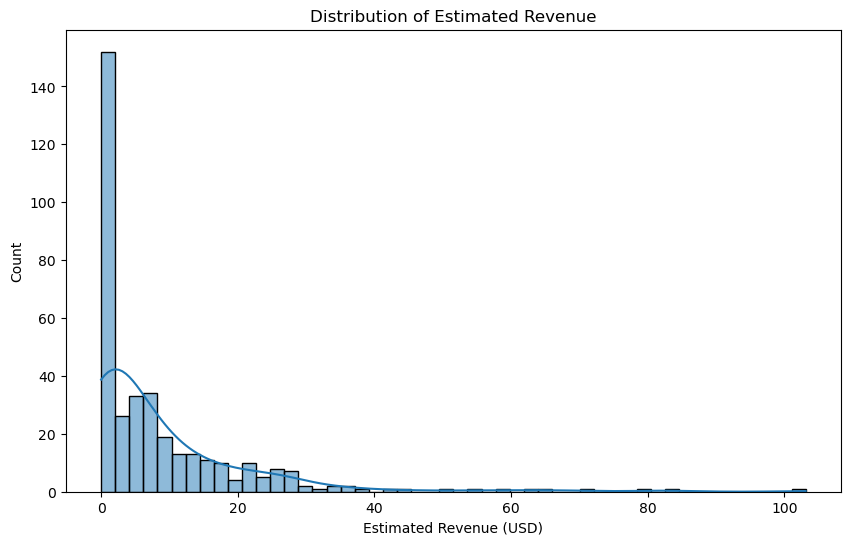

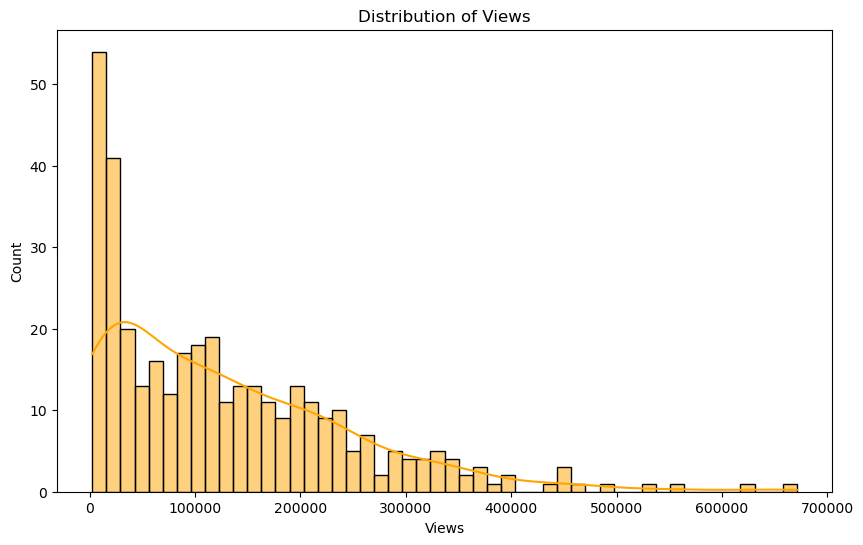

In [15]:
# Distribution plots
plt.figure(figsize=(10, 6))
sns.histplot(data['Estimated Revenue (USD)'], bins=50, kde=True)
plt.title('Distribution of Estimated Revenue')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(data['Views'], bins=50, kde=True, color='orange')
plt.title('Distribution of Views')
plt.show()


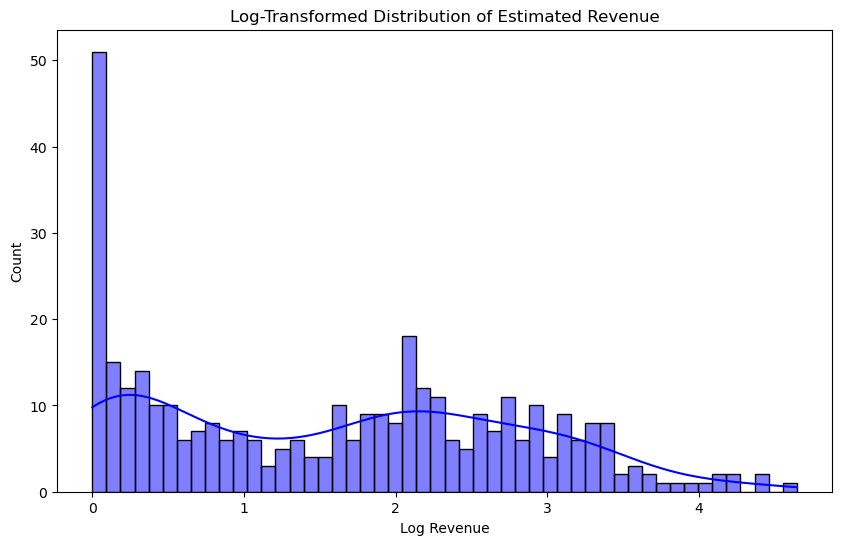

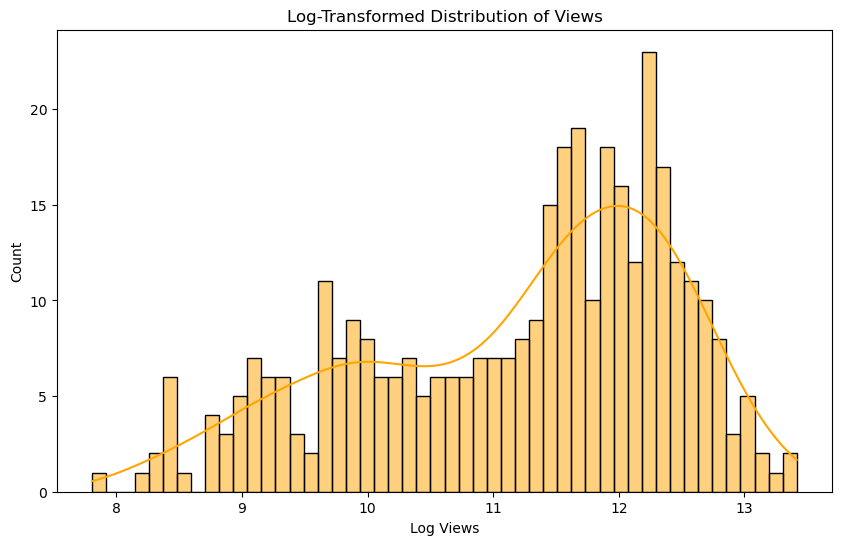

In [16]:
# Log transform the data
data['Log Revenue'] = np.log1p(data['Estimated Revenue (USD)'])
data['Log Views'] = np.log1p(data['Views'])

# Plot the log-transformed distributions
plt.figure(figsize=(10, 6))
sns.histplot(data['Log Revenue'], bins=50, kde=True, color='blue')
plt.title('Log-Transformed Distribution of Estimated Revenue')
plt.xlabel('Log Revenue')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(data['Log Views'], bins=50, kde=True, color='orange')
plt.title('Log-Transformed Distribution of Views')
plt.xlabel('Log Views')
plt.show()


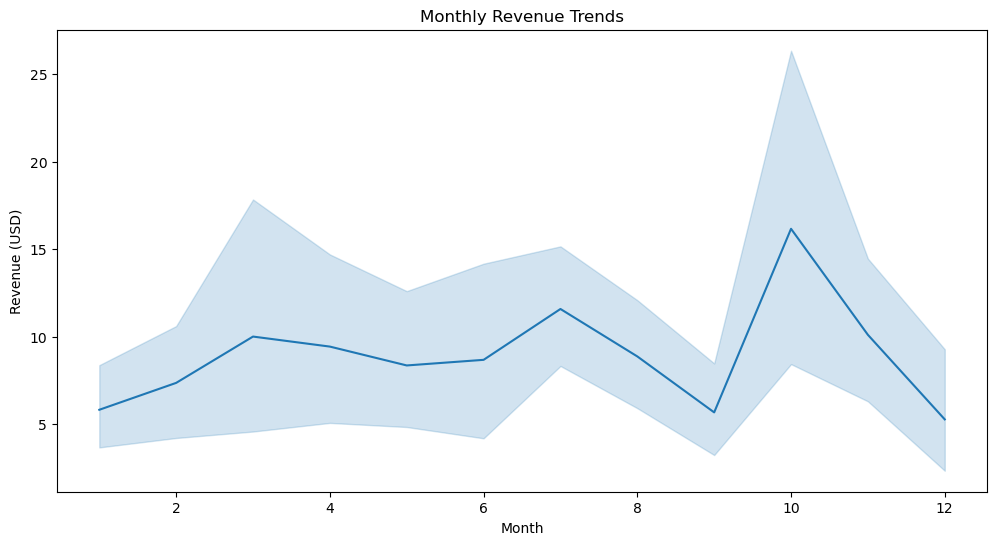

In [17]:
# Time-based trends (Publish Month vs. Revenue)
plt.figure(figsize=(12, 6))
sns.lineplot(x='Publish Month', y='Estimated Revenue (USD)', data=data)
plt.title('Monthly Revenue Trends')
plt.xlabel('Month')
plt.ylabel('Revenue (USD)')
plt.show()

Feature selection

In [18]:
# Check correlation of features with revenue
corr_with_revenue = data.corr()['Estimated Revenue (USD)'].sort_values(ascending=False)
print(corr_with_revenue)

Estimated Revenue (USD)            1.000000
Watch Page Ads Revenue (USD)       0.999493
YouTube Ads Revenue (USD)          0.999471
Estimated AdSense Revenue (USD)    0.995314
Monetized Playbacks (Estimate)     0.944155
                                     ...   
Returning Viewers                       NaN
New Viewers                             NaN
Average Views per User                  NaN
Unique Viewers                          NaN
Publish Hour                            NaN
Name: Estimated Revenue (USD), Length: 79, dtype: float64


C:\Users\hp\AppData\Local\Temp\ipykernel_9168\578937119.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_with_revenue = data.corr()['Estimated Revenue (USD)'].sort_values(ascending=False)


Ad Impressions              0.385742
Ad Impressions              0.374295
Subscribers                 0.062509
Engagement Rate             0.061482
Playback-Based CPM (USD)    0.059363
Watch Time (hours)          0.024534
Views                       0.017453
Video Duration              0.014622
dtype: float64


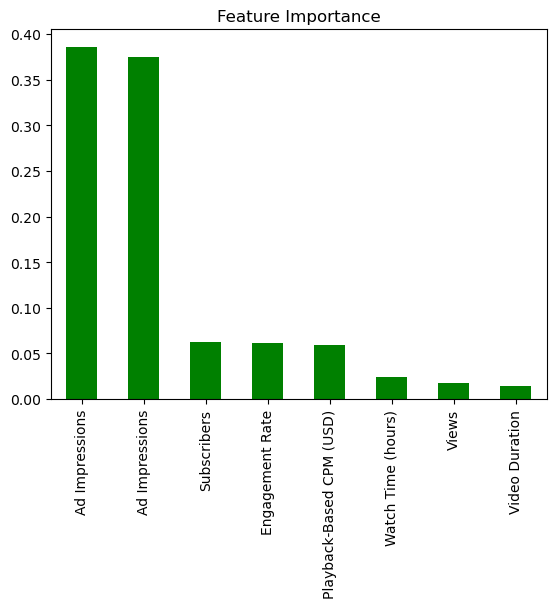

In [26]:
from sklearn.ensemble import RandomForestRegressor

# Select features and target
X = data[['Views', 'Watch Time (hours)', 'Subscribers', 'Engagement Rate','Ad Impressions','Video Duration','Playback-Based CPM (USD)','Ad Impressions']]
y = data['Estimated Revenue (USD)']

# Train a simple model
model = RandomForestRegressor(random_state=42)
model.fit(X, y)

# Feature importance
feature_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print(feature_importance)

# Plot feature importance
feature_importance.plot(kind='bar', color='green')
plt.title('Feature Importance')
plt.show()

In [27]:
from sklearn.linear_model import LinearRegression
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluate
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))


MSE: 29.334230486818555
R2 Score: 0.6630816660177035


In [29]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmse

5.416108426427462

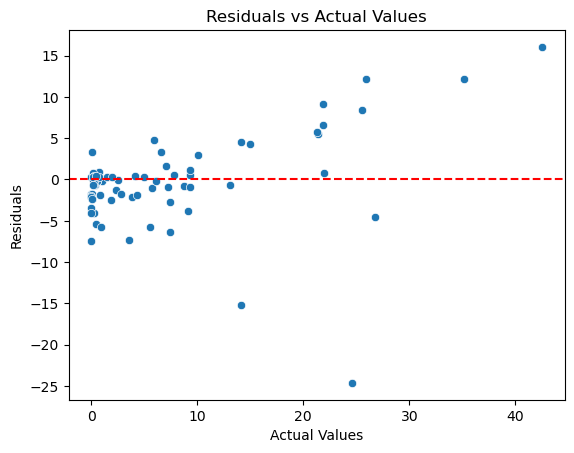

In [30]:
residuals = y_test - y_pred
sns.scatterplot(x=y_test, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.show()
